## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "law_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [11]:
dataset_orig.features.shape

(20798, 13)

In [12]:
privileged_groups

[{'gender': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[10. 10.  0. ...  3.  6.  6.]
 [ 6.  6.  0. ...  3.  5.  5.]
 [ 5.  4.  0. ...  3.  6.  7.]
 ...
 [ 3.  6.  0. ...  3.  5.  5.]
 [ 3.  3.  0. ...  5.  6.  8.]
 [ 1.  1.  0. ...  4.  4.  4.]]


In [14]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights features                                  \
                                                                           
                                 decile3 decile1 race cluster  lsat ugpa   
instance names                                                             
14111                       1.0     10.0    10.0  0.0     3.0  33.0  3.7   
11729                       1.0      6.0     6.0  0.0     3.0  36.0  2.6   
8840                        1.0      5.0     4.0  0.0     3.0  36.0  3.5   
4722                        1.0     10.0    10.0  0.0     3.0  42.0  3.1   
1970                        1.0      7.0     7.0  0.0     2.0  33.0  2.5   
...                         ...      ...     ...  ...     ...   ...  ...   
372                         1.0      9.0     8.0  0.0     1.0  45.0  2.3   
1926                        1.0      8.0     8.0  0.0     4.0  40.0  3.2   
7125                        1.0      3.0     6.0  0.0     3.0  35.0  2.9   
10585       

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [17]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    train_test_egr, egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[4. 3. 0. ... 5. 6. 8.]
 [9. 7. 0. ... 3. 6. 6.]
 [8. 8. 0. ... 4. 6. 6.]
 ...
 [2. 1. 1. ... 2. 4. 4.]
 [3. 5. 0. ... 4. 6. 6.]
 [6. 5. 0. ... 4. 6. 8.]]
no bias type specified
#### Training Dataset shape
(10399, 13)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['decile3', 'decile1', 'race', 'cluster', 'lsat', 'ugpa', 'dob_yr', 'fulltime', 'fam_inc', 'gender', 'tier', 'indxgrp', 'indxgrp2']
privileged vs. unprivileged:  5834.0 4565.0
base_pos unpriv:  0.9415115005476451
base_pos priv:  0.9530339389784025
number of favorable labels:  9858
Difference in mean outcomes between unprivileged and privileged groups = -0.011522
#### Train shape, validation shape, test shape
(10399, 13) (10399, 13) (10399, 13)
####

Number of training samples (ntrain): 5560
Number of test samples (ntest): 5590
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.5270203096859712
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 541, Test = 499
  AUC: 0.74
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.35
  Positive predictive value: 0.78
  Optimal thershold: -1.7917594692280552
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9858, Test = 9900
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.02
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.5270203096859712
)
MIA_Result(
  Na

Number of training samples (ntrain): 4298
Number of test samples (ntest): 4310
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 274
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5560
Number of test samples (ntest): 5590
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -1.0986122886681096
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 541, Test = 499
  AUC: 0.72
  Privacy Risk: 0.66
  Accuracy: 0.65
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.31
  Positive predictive value: 0.78
  Optimal thershold: -1.6094379124341005
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9858, Test = 9900
 

Number of training samples (ntrain): 4298
Number of test samples (ntest): 4310
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 274
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5560
Number of test samples (ntest): 5590
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: -1.203972804325936
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 541, Test = 499
  AUC: 0.75
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.55
  Test Accuracy (TNR): 0.81
  Attacker advantage: 0.36
  Positive predictive value: 0.80
  Optimal thershold: -1.203972804325936
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9858, Test = 9900
  A

Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4298
Number of test samples (ntest): 4310
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 274
Number of test samples (ntest): 251
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5560
Number of test samples (ntest): 5590
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.6735026516524222
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 541, Test = 499
  AUC: 0.75
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.36
  Positive predictive value: 0.79
  Optimal thershold: -1.5710089689262774
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the D

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.0669295124531205
Balanced accuracy is:  0.41194510232586384
Accuracy for threshold: 0.02  is: 0.0669295124531205
Balanced accuracy is:  0.41194510232586384
Accuracy for threshold: 0.03  is: 0.0669295124531205
Balanced accuracy is:  0.41194510232586384
Accuracy for threshold: 0.04  is: 0.0669295124531205
Balanced accuracy is:  0.41194510232586384
Accuracy for threshold: 0.05  is: 0.0669295124531205
Balanced accuracy is:  0.41194510232586384
Accuracy for threshold: 0.060000000000000005  is: 0.0669295124531205
Balanced accuracy is:  0.41194510232586384
Accuracy for threshold: 0.06999999999999999  is: 0.0669295124531205
Balanced accuracy is:  0.41194510232586384
Accuracy for threshold: 0.08  is: 0.0669295124531205
Balanced accuracy is:  0.41194510232586384
Accuracy for threshold: 0.09  is: 0.0669295124531205
Balanced accuracy is:  0.41194510232586384
Accuracy for threshold: 0.09999999999999999  is: 0.0669295124531205
Balanced accuracy is:  0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.12      0.22       248
         1.0       0.00      0.00      0.00         0

    accuracy                           0.12       248
   macro avg       0.50      0.06      0.11       248
weighted avg       1.00      0.12      0.22       248

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99      4310

    accuracy                           0.98      4310
   macro avg       0.50      0.49      0.50      4310
weighted avg       1.00      0.98      0.99      4310

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.18      0.30       251
         1.0       0.00      0.00      0.00         0

    accuracy                           0.18       251
   macro avg       0.50   

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 248
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -2.639057329615259
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.74
  Privacy Risk: 0.69
  Accuracy: 0.70
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.39
  Positive predictive valu

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -2.0794415416798357
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.71
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.31
  Positive predictive value: 0.73
  Optimal thershold: -2.0794415416798357
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
 

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -2.367123614131617
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.73
  Privacy Risk: 0.68
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.37
  Positive predictive value: 0.71
  Optimal thershold: -2.367123614131617
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  A

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: -2.712329858096854
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.73
  Privacy Risk: 0.66
  Accuracy: 0.66
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.33
  Positive predictive value: 0.74
  Optimal thershold: -2.084845271566609
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  A

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.0758726800653909
Balanced accuracy is:  0.4071760264425317
Accuracy for threshold: 0.02  is: 0.0758726800653909
Balanced accuracy is:  0.4071760264425317
Accuracy for threshold: 0.03  is: 0.0758726800653909
Balanced accuracy is:  0.4071760264425317
Accuracy for threshold: 0.04  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.05  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.060000000000000005  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.06999999999999999  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.08  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.09  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.09999999999999999  is: 0.060390422155976536
Balanced accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99      5523

    accuracy                           0.98      5523
   macro avg       0.50      0.49      0.50      5523
weighted avg       1.00      0.98      0.99      5523

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 248
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR):

Accuracy for threshold: 0.45  is: 0.9423021444369651
Balanced accuracy is:  0.5921519057617991
Accuracy for threshold: 0.46  is: 0.9423021444369651
Balanced accuracy is:  0.5921519057617991
Accuracy for threshold: 0.47000000000000003  is: 0.9423021444369651
Balanced accuracy is:  0.5921519057617991
Accuracy for threshold: 0.48000000000000004  is: 0.9423021444369651
Balanced accuracy is:  0.5921519057617991
Accuracy for threshold: 0.49  is: 0.9423021444369651
Balanced accuracy is:  0.5921519057617991
Accuracy for threshold: 0.5  is: 0.9414366766035196
Balanced accuracy is:  0.5963460093310253
Best thresh:  0.5
Best balanced accuracy: 0.5963
Corresponding 1-min(DI, 1/DI) value: 0.9934
Corresponding average odds difference value: -0.0062
Corresponding statistical parity difference value: -0.0064
Corresponding equal opportunity difference value: -0.0046
Corresponding Theil index value: 0.0341
Corresponding false positive_rate for privileged: 0.7901
Corresponding false negative_rate for pri

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -2.0794415416798357
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.71
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.31
  Positive predictive value: 0.73
  Optimal thershold: -2.0794415416798357
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
 

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -2.367123614131617
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.73
  Privacy Risk: 0.68
  Accuracy: 0.69
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.37
  Positive predictive value: 0.71
  Optimal thershold: -2.367123614131617
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  A

Accuracy for threshold: 0.47000000000000003  is: 0.9418213289739398
Balanced accuracy is:  0.5826007903414172
True positive rate is:  0.9808878551926383
True negative rate is:  0.1843137254901961
Balanced accuracy is:  0.5826007903414172
Test Accuracy is:  0.9418213289739398
Best balanced accuracy: 0.5826
Corresponding 1-min(DI, 1/DI) value: 0.9911
Corresponding average odds difference value: -0.0235
Corresponding statistical parity difference value: -0.0087
Corresponding equal opportunity difference value: -0.0056
Corresponding Theil index value: 0.0327
Corresponding false positive_rate for privileged: 0.8359
Corresponding false negative_rate for privileged: 0.0167
Corresponding false positive_rate for unpribileged: 0.7944
Corresponding false negative_rate for unprivileged: 0.0222
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 248
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test sam

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.0758726800653909
Balanced accuracy is:  0.4071760264425317
Accuracy for threshold: 0.02  is: 0.0758726800653909
Balanced accuracy is:  0.4071760264425317
Accuracy for threshold: 0.03  is: 0.0758726800653909
Balanced accuracy is:  0.4071760264425317
Accuracy for threshold: 0.04  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.05  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.060000000000000005  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.06999999999999999  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.08  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.09  is: 0.060390422155976536
Balanced accuracy is:  0.43250958184871685
Accuracy for threshold: 0.09999999999999999  is: 0.060390422155976536
Balanced accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.30       248
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17       248
   macro avg       0.50      0.09      0.15       248
weighted avg       1.00      0.17      0.30       248

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99      4366

    accuracy                           0.98      4366
   macro avg       0.50      0.49      0.49      4366
weighted avg       1.00      0.98      0.99      4366

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.13      0.22       262
         1.0       0.00      0.00      0.00         0

    accuracy                           0.13       262
   macro avg       0.50   

In [65]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()
df_bank['gender'].value_counts()

gender
1.0    11675
0.0     9123
Name: count, dtype: int64

In [67]:
age_counts = df_bank['gender'].value_counts()


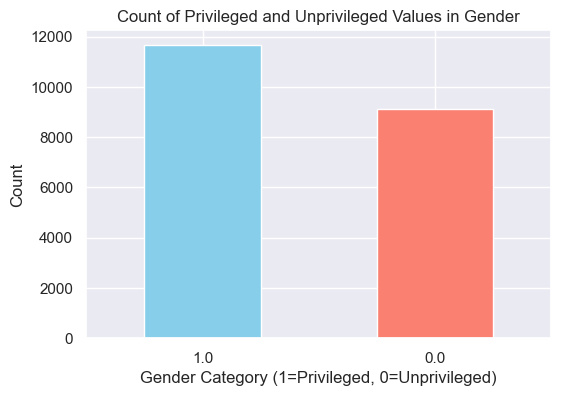

In [68]:
# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [69]:
df_bank.shape

(20798, 14)

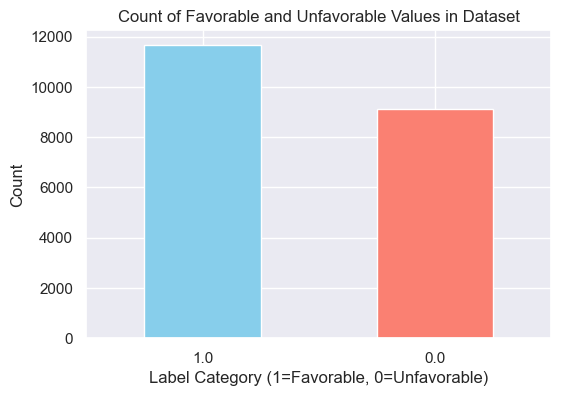

In [70]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['pass_bar'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## Display Output

In [18]:
priv_metric_orig_copy = priv_metric_orig

In [19]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 17614.0, 'total_unpriv': 13583.0})

In [20]:
priv_metric_orig

defaultdict(float, {'total_priv': 17614.0, 'total_unpriv': 13583.0})

In [21]:
priv_metric_orig = priv_metric_orig_copy

1)

law_sex
10399
2)

               total_priv  total_unpriv
num_instance                           
orig          5871.333333   4527.666667
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.948681       0.051319    0.954577      0.045423      0.941027   
transf      0.954574       0.045426    0.954577      0.045423      0.954571   

         unpriv_unfavor  
dataset                  
orig           0.058973  
transf         0.045429  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.583657       0.004864  0.005900      -0.002751   
dt_syn                     0.569777      -0.018373  0.005422      -0.005309   
dt_dir                     0.581327      -0.027309  0.013269      -0.012934   
dt_rew                     0.57437

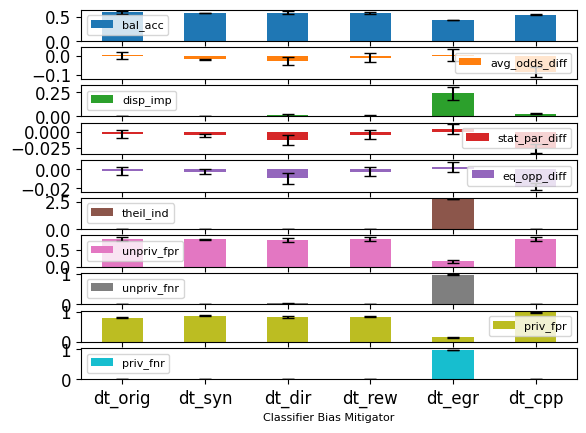

In [22]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

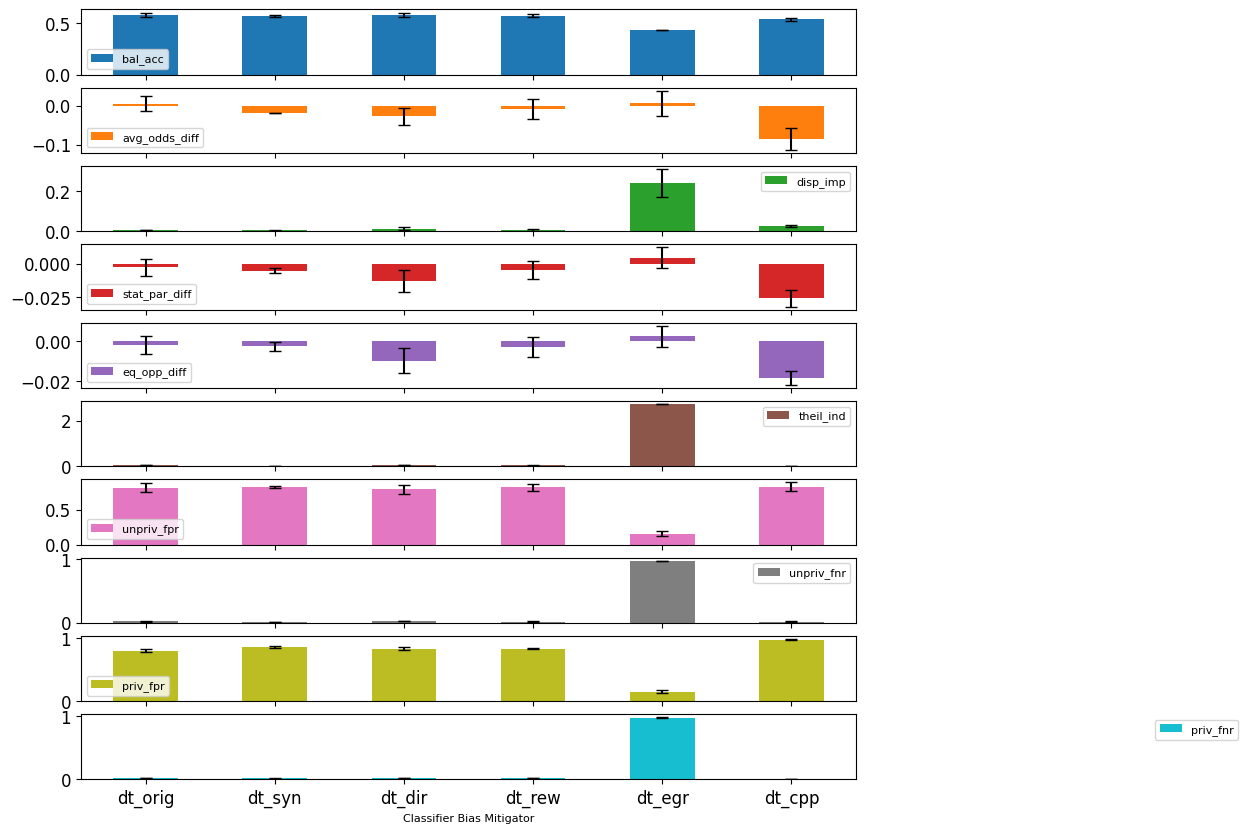

In [23]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [24]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.583657,0.004864,0.005900,-0.002751,-0.001875,0.034629,0.817204,0.022301,0.805602,0.020426
dt_syn,0.569777,-0.018373,0.005422,-0.005309,-0.002437,0.030322,0.826613,0.017703,0.860923,0.015266
dt_dir,0.581327,-0.027309,0.013269,-0.012934,-0.009703,0.036008,0.791667,0.028034,0.836582,0.018332
dt_rew,0.574379,-0.008812,0.007079,-0.004740,-0.002756,0.033264,0.823925,0.021076,0.838792,0.018320
dt_egr,0.434193,0.006232,0.238984,0.004302,0.002698,2.719274,0.157258,0.978081,0.147491,0.980779
dt_cpp,0.540800,-0.084932,0.025819,-0.025738,-0.018432,0.025393,0.830645,0.020602,0.982077,0.002170


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [25]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [26]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.516604,0.687507,0.509970,0.682969,0.511127,0.693855,0.510641
syn,0.513287,0.655203,0.507884,0.662053,0.510408,0.653699,0.508083
dir,0.516508,0.682606,0.511003,0.676327,0.516608,0.689260,0.509054
rew,0.514681,0.669013,0.509789,0.670993,0.511606,0.675699,0.508782
egr,0.517373,0.680712,0.513889,0.668325,0.511372,0.694601,0.515988


In [27]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [28]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [29]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.682969,0.511127,0.693855,0.510641
syn,0.662053,0.510408,0.653699,0.508083
dir,0.676327,0.516608,0.689260,0.509054
rew,0.670993,0.511606,0.675699,0.508782
egr,0.668325,0.511372,0.694601,0.515988


<Axes: xlabel='Classifier MIA Attacks'>

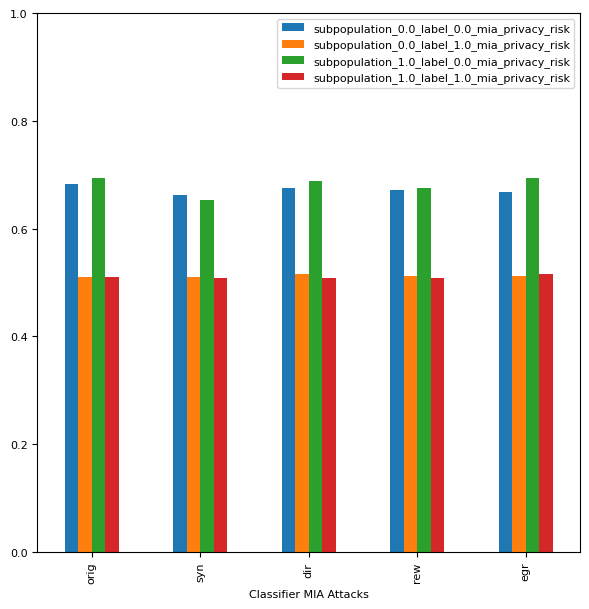

In [30]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [31]:
# Tabular Format
# importing the modules
from tabulate import tabulate

# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.682969  0.662053  0.676327  0.670993  0.668325
subpopulation_0.0_label_1.0_mia_privacy_risk  0.511127  0.510408  0.516608  0.511606  0.511372
subpopulation_1.0_label_0.0_mia_privacy_risk  0.693855  0.653699  0.68926   0.675699  0.694601
subpopulation_1.0_label_1.0_mia_privacy_risk  0.510641  0.508083  0.509054  0.508782  0.515988


### Visualizing using novel technique

In [32]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [33]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [34]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.513847
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517982
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.673174
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.694673
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.718116
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.718116
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.512330
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.517817


In [35]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.513847
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517982
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.689207
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.679851
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.718116
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.718116
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.512330
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.517817


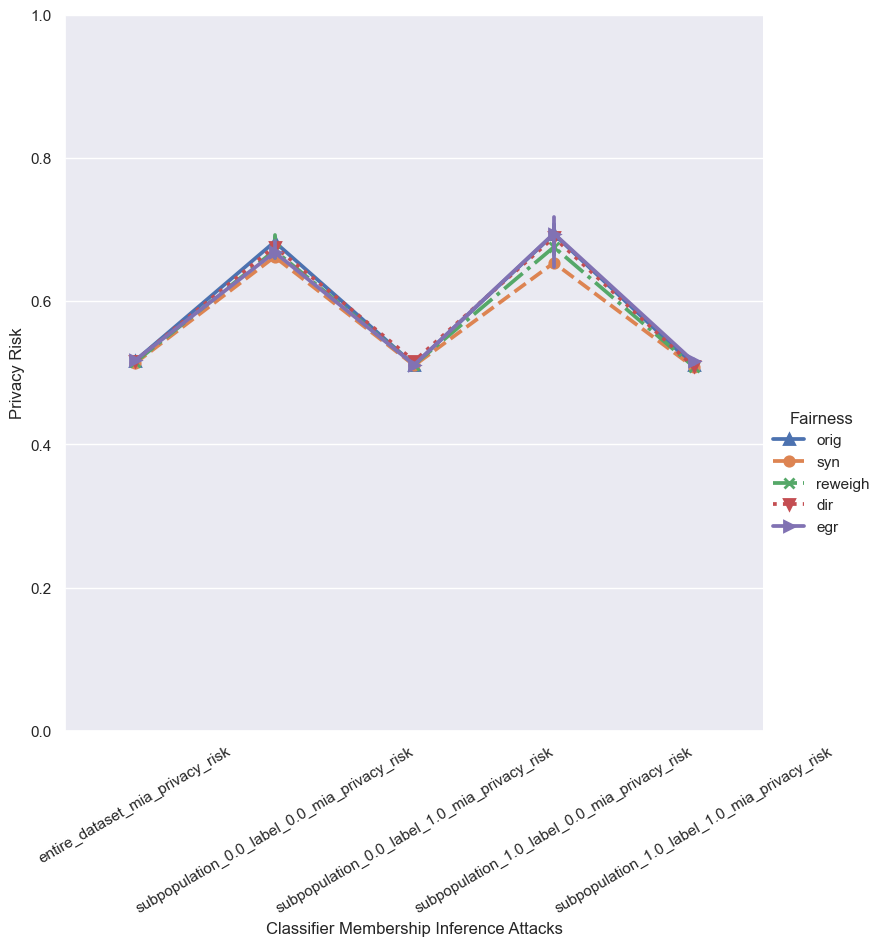

In [36]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [37]:
from sklearn.metrics import RocCurveDisplay, auc

In [38]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

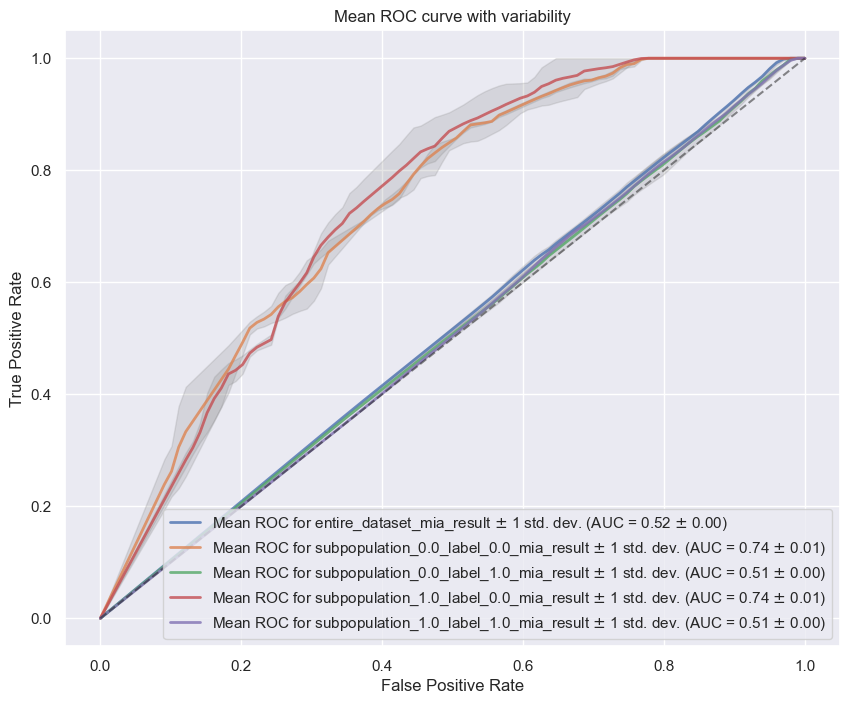

In [39]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

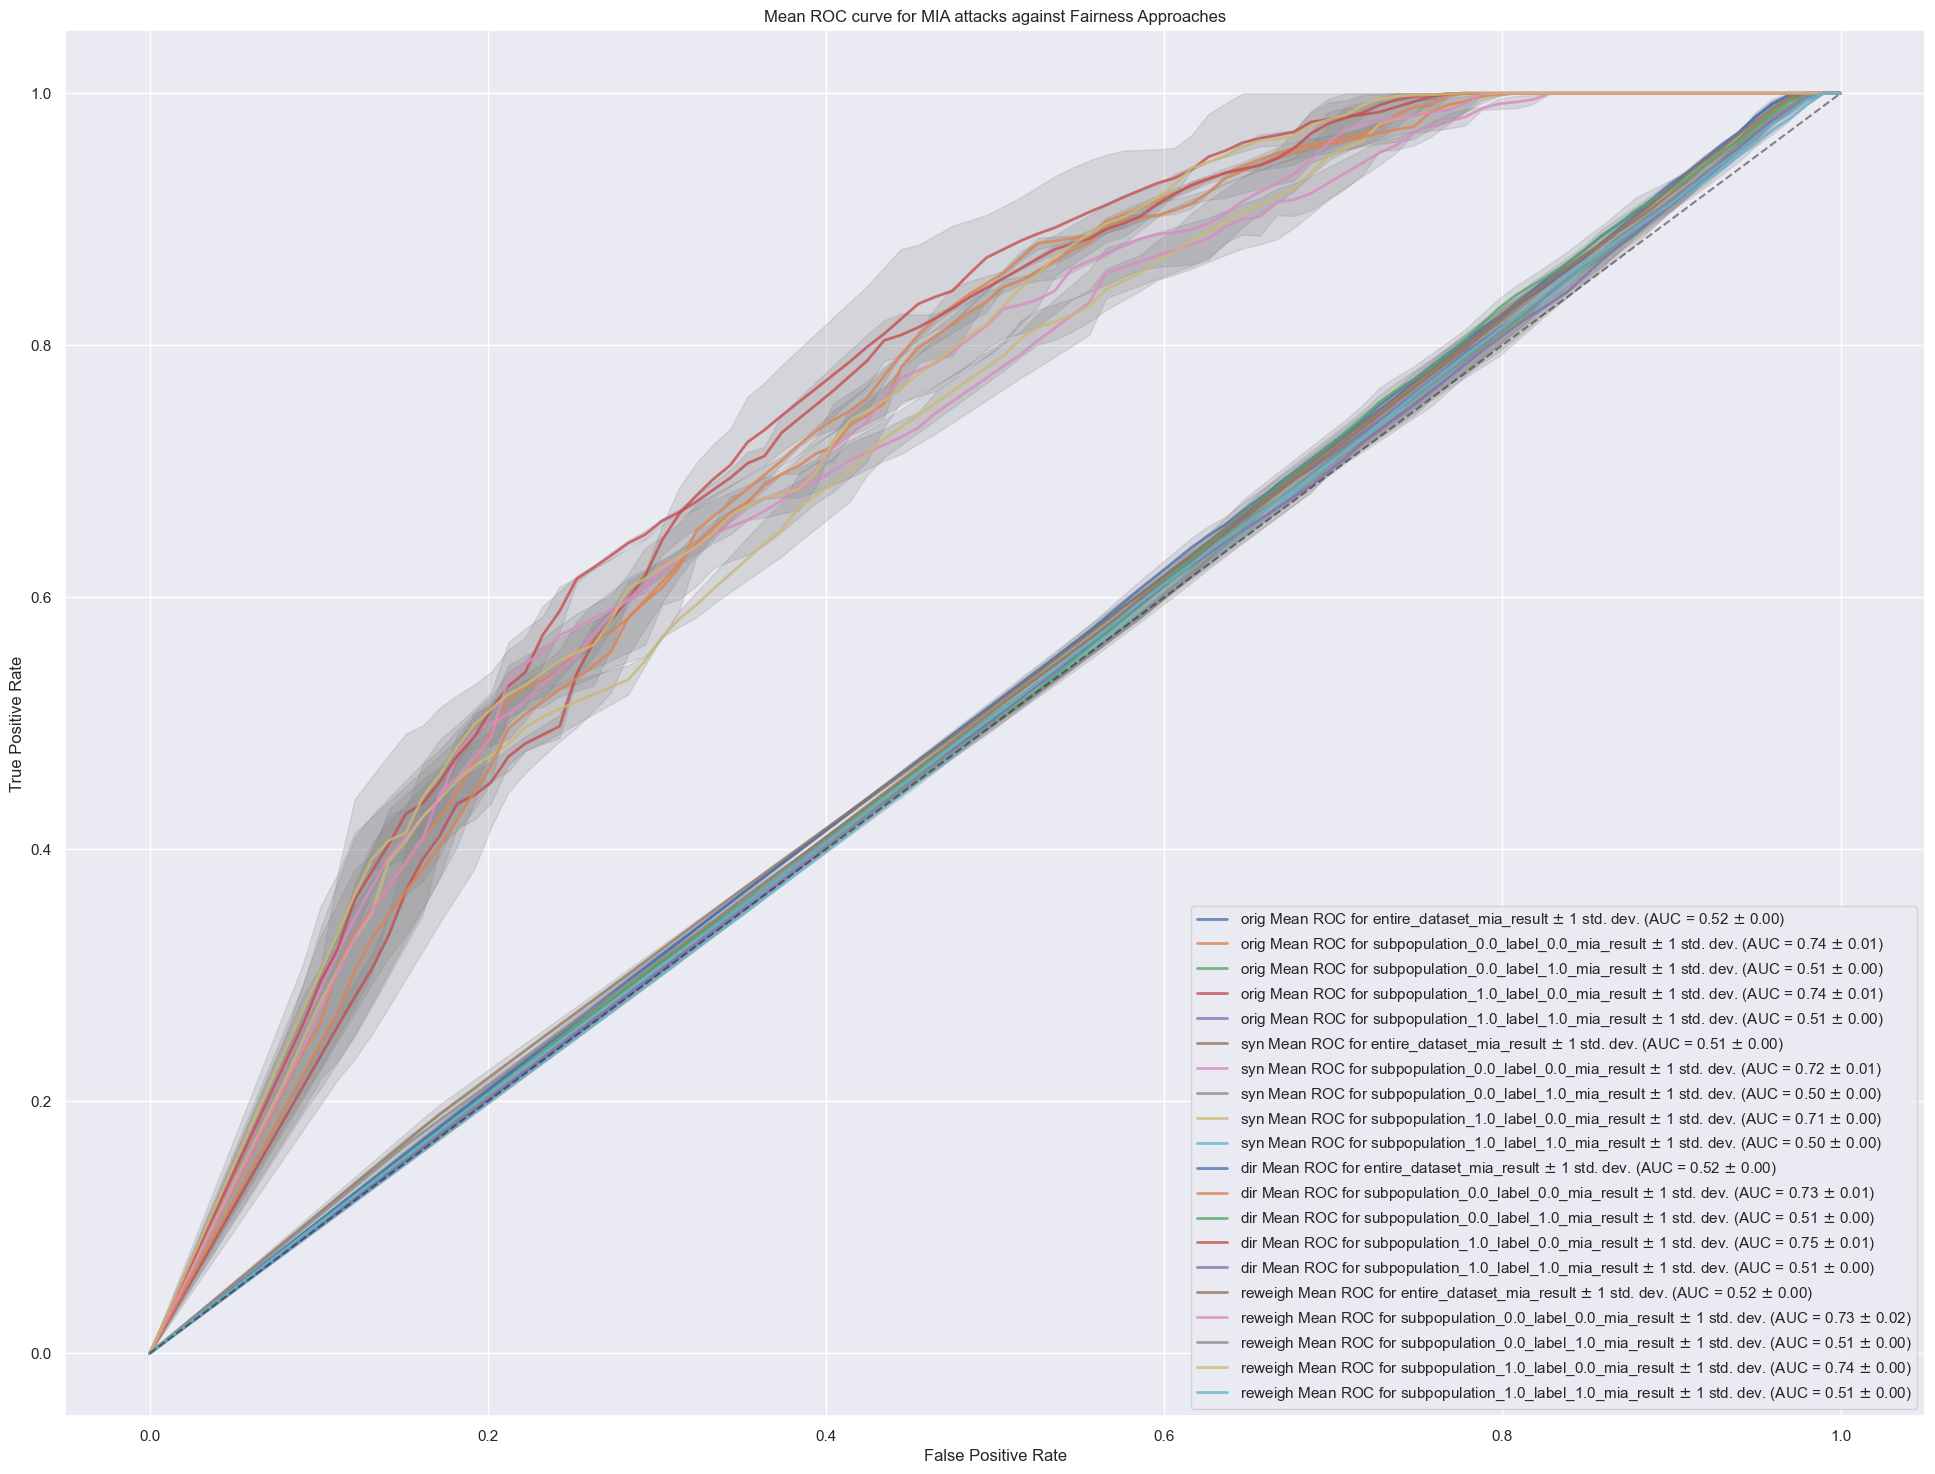

In [40]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

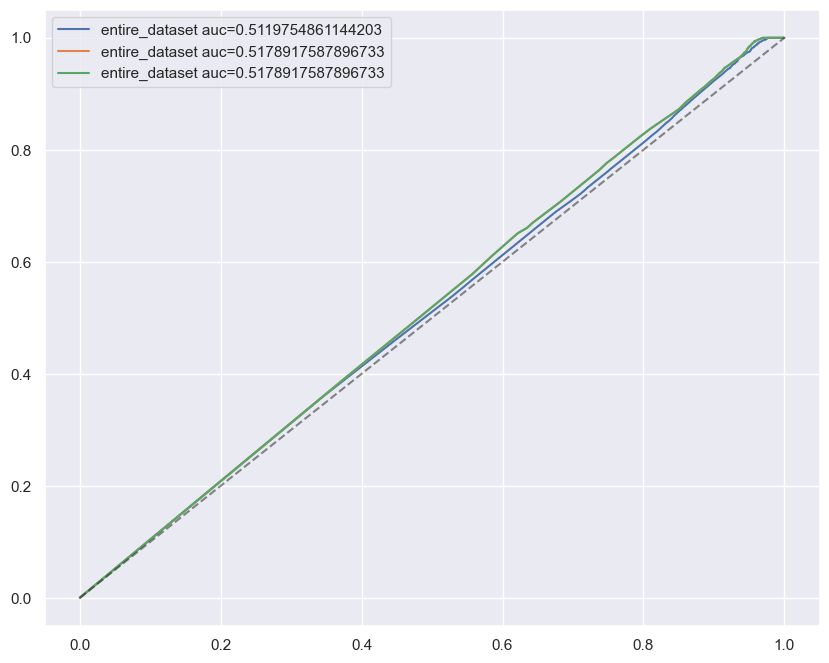

In [41]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [42]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [43]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5159196678979224,
 'entire_dataset_label_0.0_mia_auc': 0.7369567581317599,
 'entire_dataset_label_1.0_mia_auc': 0.5078296885651742,
 'subpopulation_0.0_label_0.0_mia_auc': 0.736017981555314,
 'subpopulation_0.0_label_1.0_mia_auc': 0.5086080424512703,
 'subpopulation_1.0_label_0.0_mia_auc': 0.739474632110463,
 'subpopulation_1.0_label_1.0_mia_auc': 0.5069629438138696}

In [44]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.515920,0.736957,0.507830,0.736018,0.508608,0.739475,0.506963
syn,0.511955,0.715579,0.503830,0.719421,0.504836,0.712532,0.503091
dir,0.516330,0.737666,0.508161,0.726451,0.512164,0.748268,0.505259
rew,0.517452,0.734242,0.508456,0.728122,0.508808,0.739551,0.508007


<Axes: xlabel='Classifier MIA Attacks'>

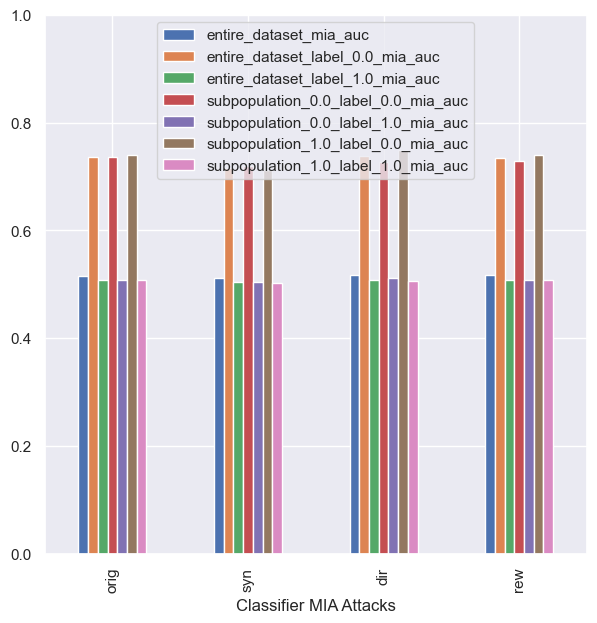

In [45]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [46]:
# Creating data structures to plot point categorical plot from seaborn

In [47]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [48]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.027694970670256835,
  0.03596499663429176,
  0.03596499663429176],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.3463488900166321,
  0.3893451720310766,
  0.3893451720310766],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.017858561266960615,
  0.020981009583312615,
  0.020981009583312615],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.37841307236921584,
  0.3597015826990456,
  0.3597015826990456],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.016923751294240397,
  0.024920396627058805,
  0.024920396627058805],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.3299357315264489,
  0.41659652279917564,
  0.41659652279917564],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.02112971519028073,
  0.021357220130651555,
  0.021357220130651555]}

In [49]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.027694970670256835],
 ['orig', 'entire_dataset', 0.03596499663429176],
 ['orig', 'entire_dataset', 0.03596499663429176],
 ['orig', 'entire_dataset_label_0.0', 0.3463488900166321],
 ['orig', 'entire_dataset_label_0.0', 0.3893451720310766],
 ['orig', 'entire_dataset_label_0.0', 0.3893451720310766],
 ['orig', 'entire_dataset_label_1.0', 0.017858561266960615],
 ['orig', 'entire_dataset_label_1.0', 0.020981009583312615],
 ['orig', 'entire_dataset_label_1.0', 0.020981009583312615],
 ['orig', 'subpopulation_0.0_label_0.0', 0.37841307236921584],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3597015826990456],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3597015826990456],
 ['orig', 'subpopulation_0.0_label_1.0', 0.016923751294240397],
 ['orig', 'subpopulation_0.0_label_1.0', 0.024920396627058805],
 ['orig', 'subpopulation_0.0_label_1.0', 0.024920396627058805],
 ['orig', 'subpopulation_1.0_label_0.0', 0.3299357315264489],
 ['orig', 'subpopulation_1.0_label_0.0', 0.41659

In [50]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.027695
1,orig,entire_dataset,0.035965
2,orig,entire_dataset,0.035965
3,orig,entire_dataset_label_0.0,0.346349
4,orig,entire_dataset_label_0.0,0.389345
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.436232
101,egr,subpopulation_1.0_label_0.0,0.436232
102,egr,subpopulation_1.0_label_1.0,0.024661
103,egr,subpopulation_1.0_label_1.0,0.035635


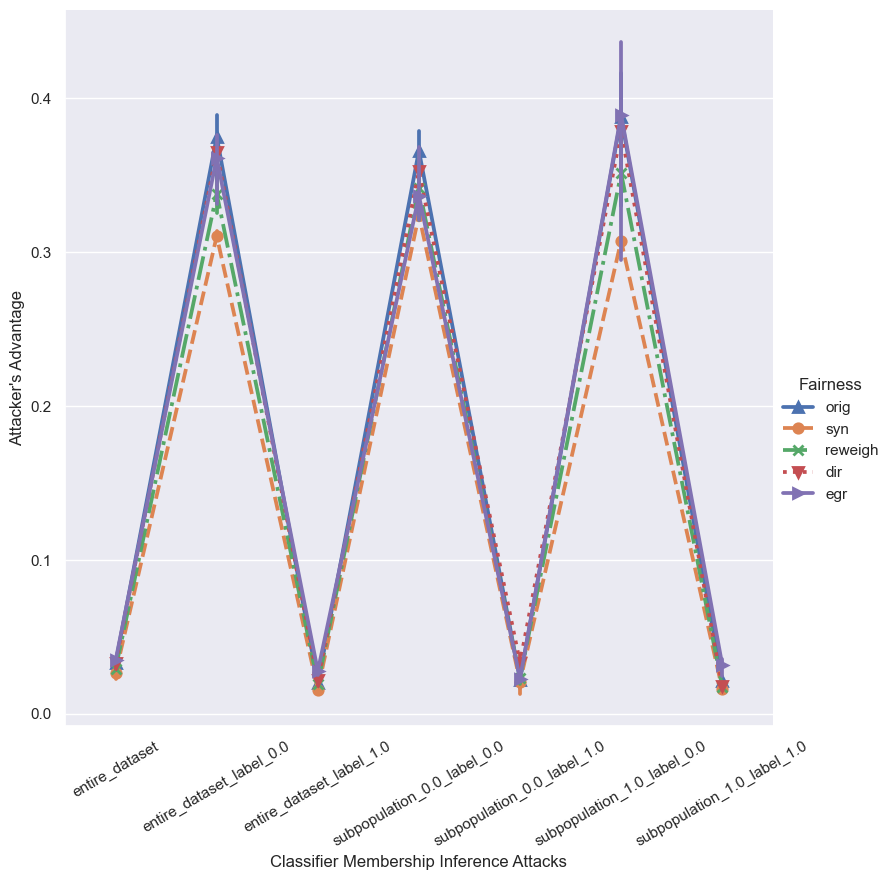

In [51]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


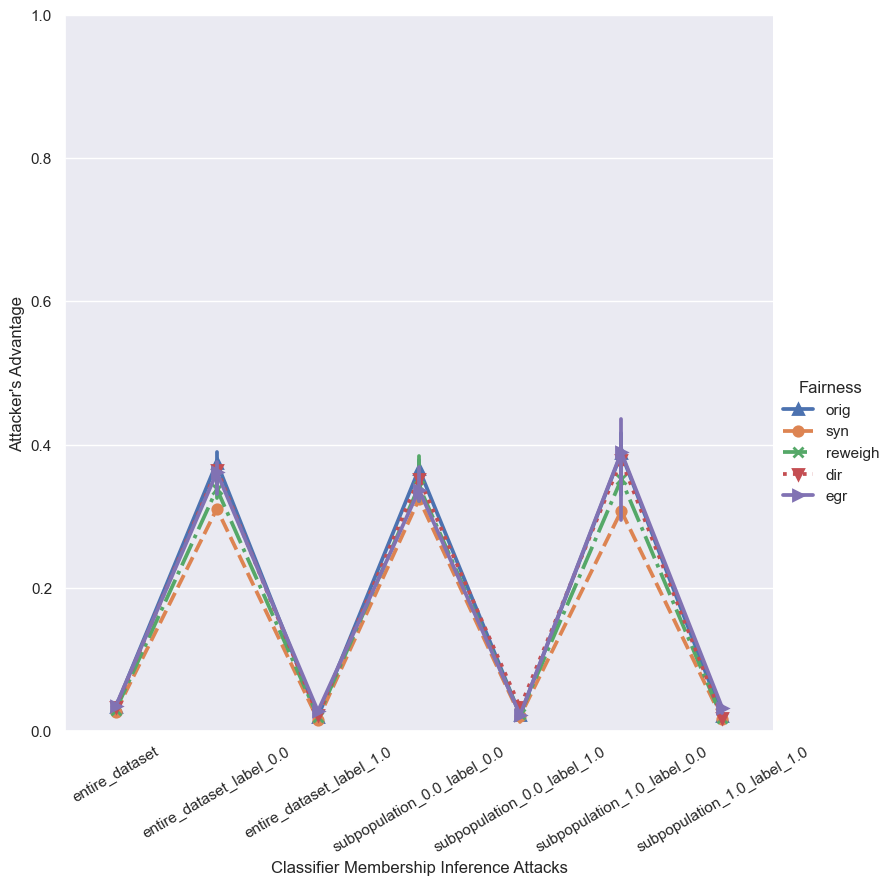

In [52]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [53]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.027695,0.346349,0.017859,0.378413,0.016924,0.329936,0.021130
1,0.035965,0.389345,0.020981,0.359702,0.024920,0.416597,0.021357
2,0.035965,0.389345,0.020981,0.359702,0.024920,0.416597,0.021357


In [54]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [55]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.033208321312946786,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.37501307802626177,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.01994019347786195,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.3659387459224357,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.022254848182786002,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.3877095923749334,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.021281385150527948}

In [56]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.033208,0.375013,0.019940,0.365939,0.022255,0.387710,0.021281
syn,0.026573,0.310407,0.015769,0.324106,0.020816,0.307399,0.016165
dir,0.033016,0.365211,0.022006,0.352654,0.033215,0.378520,0.018108
rew,0.029362,0.338027,0.019577,0.341987,0.023211,0.351398,0.017564
egr,0.034747,0.361424,0.027778,0.336651,0.022744,0.389202,0.031977


<Axes: xlabel='Classifier MIA Attacks'>

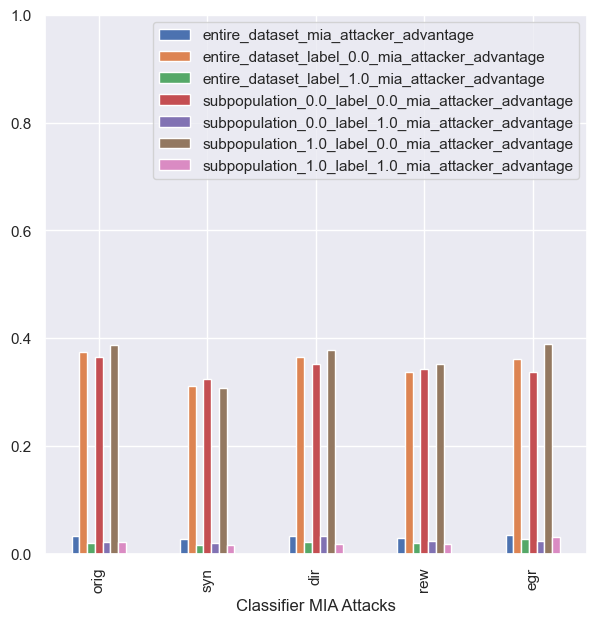

In [57]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [58]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [59]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5100341296928328],
 ['orig', 'entire_dataset', 0.511522478277295],
 ['orig', 'entire_dataset', 0.511522478277295],
 ['orig', 'entire_dataset_label_0.0', 0.7774193548387097],
 ['orig', 'entire_dataset_label_0.0', 0.7117117117117118],
 ['orig', 'entire_dataset_label_0.0', 0.7117117117117118],
 ['orig', 'entire_dataset_label_1.0', 0.503501986201129],
 ['orig', 'entire_dataset_label_1.0', 0.5069997679634929],
 ['orig', 'entire_dataset_label_1.0', 0.5069997679634929],
 ['orig', 'subpopulation_0.0_label_0.0', 0.806896551724138],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7219251336898396],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7219251336898396],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5065359477124182],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5007407407407407],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5007407407407407],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7515151515151516],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7058823529411765],
 ['orig

In [60]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.510034
1,orig,entire_dataset,0.511522
2,orig,entire_dataset,0.511522
3,orig,entire_dataset_label_0.0,0.777419
4,orig,entire_dataset_label_0.0,0.711712
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.813559
101,egr,subpopulation_1.0_label_0.0,0.813559
102,egr,subpopulation_1.0_label_1.0,0.504928
103,egr,subpopulation_1.0_label_1.0,0.513895


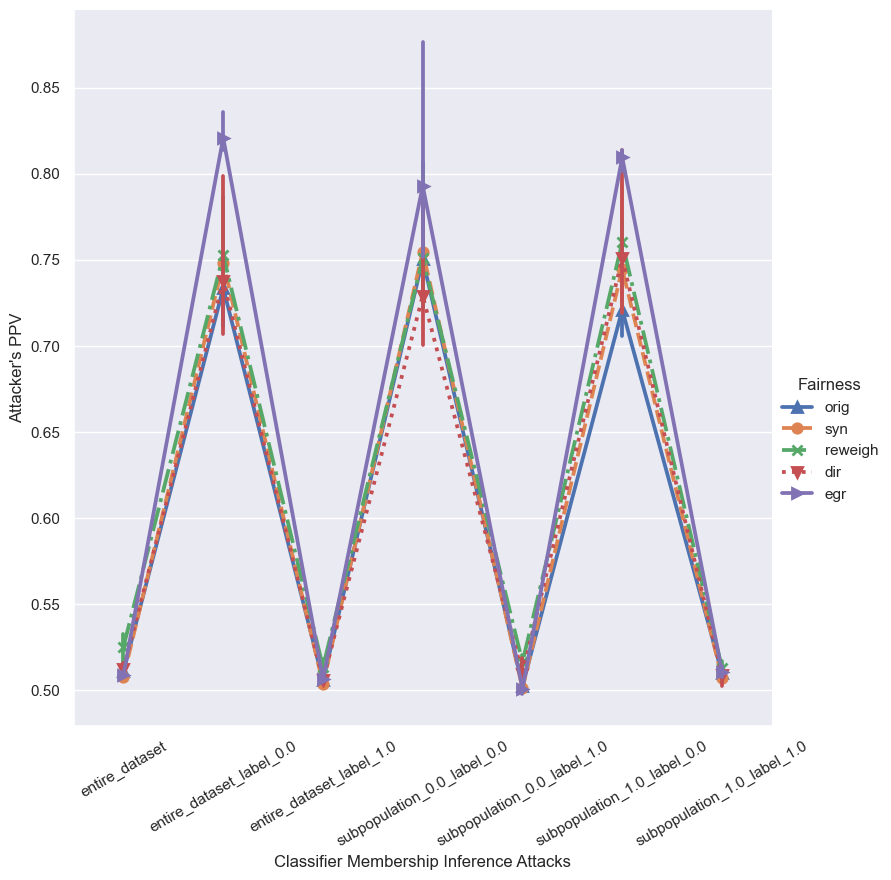

In [61]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [62]:
import pandas as pd

In [63]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,decile3,decile1,race,cluster,lsat,ugpa,dob_yr,fulltime,fam_inc,gender,tier,indxgrp,indxgrp2,labels
0,10.0,10.0,0.0,1.0,44.0,3.5,69.0,1.0,5.0,0.0,4.0,6.0,8.0,1.0
1,4.0,5.0,0.0,2.0,29.0,3.5,69.0,1.0,4.0,0.0,2.0,5.0,5.0,1.0
2,7.0,8.0,0.0,1.0,37.0,3.4,68.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0
3,7.0,8.0,0.0,1.0,43.0,3.3,67.0,1.0,4.0,0.0,4.0,6.0,8.0,1.0
4,2.0,3.0,0.0,4.0,41.0,3.3,64.0,1.0,4.0,0.0,5.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20793,8.0,9.0,0.0,5.0,42.0,3.0,67.0,1.0,4.0,1.0,6.0,6.0,7.0,1.0
20794,9.0,4.0,0.0,3.0,29.5,3.5,68.0,1.0,4.0,1.0,3.0,5.0,5.0,1.0
20795,1.0,1.0,0.0,3.0,33.0,3.1,69.0,1.0,3.0,1.0,3.0,5.0,5.0,0.0
20796,5.0,4.0,0.0,3.0,32.0,3.0,67.0,0.0,3.0,1.0,3.0,5.0,5.0,1.0


In [64]:
df[["age", "labels"]].value_counts(normalize=True)

KeyError: "['age'] not in index"

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER)

In [ ]:
train_test_egr